# Activity Recognition Model


In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from model import DeepSenseModel
from tqdm import tqdm

In [2]:
# Load and preprocess data
def load_data(pickle_file_path):
    df = pd.read_pickle(pickle_file_path)
    df.rename(columns={"phone_gt": "label"}, inplace=True)

    # Remove null bytes in sensor_data
    df['acc_data'] = df['accelerometer_data'].apply(
        lambda x: x.replace('\x00', '') if isinstance(x, str) else x
    )

    df['gyro_data'] = df['gyro_data'].apply(
        lambda x: x.replace('\x00', '') if isinstance(x, str) else x
    )

    # Encode labels
    label_encoder = LabelEncoder()
    df['label'] = label_encoder.fit_transform(df['label'])

    return df, label_encoder

In [3]:
class SensorDataset(Dataset):
    def __init__(self, dataframe):
        self.labels = dataframe['label'].values
        self.acc_data = dataframe['accelerometer_data'].values
        self.gyro_data = dataframe['gyro_data'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        acc_data = torch.tensor(self.acc_data[idx], dtype=torch.float32)
        gyro_data = torch.tensor(self.gyro_data[idx], dtype=torch.float32)
        label = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return acc_data, gyro_data, label

In [6]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tqdm import tqdm


def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
    model.train()
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        running_loss = 0.0
        model.train()

        # Training loop
        for acc, gyro, labels in train_loader:
            acc, gyro, labels = acc.to(device), gyro.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(acc, gyro)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for acc, gyro, labels in test_loader:
                acc, gyro, labels = acc.to(device), gyro.to(device), labels.to(device)
                outputs = model(acc, gyro)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(test_loader)
        val_losses.append(avg_val_loss)

        if epoch + 1 % 20 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

# def train_one_epoch(model, train_loader, criterion, optimizer, device):
#     model.train()
#     running_loss = 0.0
# 
#     for acc, gyro, labels in train_loader:
#         acc, gyro, labels = acc.to(device), gyro.to(device), labels.to(device)
# 
#         # Forward pass
#         optimizer.zero_grad()
#         outputs = model(acc, gyro)
# 
#         # Compute loss
#         loss = criterion(outputs, labels)
# 
#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()
# 
#         running_loss += loss.item()
# 
#     # Average training loss
#     return running_loss / len(train_loader)
# 
# 
# def validate_one_epoch(model, test_loader, criterion, device):
#     model.eval()
#     val_loss = 0.0
# 
#     with torch.no_grad():
#         for acc, gyro, labels in test_loader:
#             acc, gyro, labels = acc.to(device), gyro.to(device), labels.to(device)
# 
#             # Forward pass
#             outputs = model(acc, gyro)
# 
#             # Compute loss
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()
# 
#     # Average validation loss
#     return val_loss / len(test_loader)
# 
# 
# def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs, device):
#     train_losses = []
#     val_losses = []
# 
#     for epoch in tqdm(range(num_epochs), desc="Training Progress"):
#         # Train and validate for one epoch
#         avg_train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
#         avg_val_loss = validate_one_epoch(model, test_loader, criterion, device)
# 
#         # Update learning rate using scheduler
#         if scheduler:
#             scheduler.step(avg_val_loss)
# 
#         # Store losses
#         train_losses.append(avg_train_loss)
#         val_losses.append(avg_val_loss)
# 
#         # Logging progress every 20 epochs
#         if (epoch + 1) % 20 == 0 or epoch == num_epochs - 1:
#             print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
# 
#     return train_losses, val_losses


def test_model(model, test_loader, device, label_encoder):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for acc, gyro, labels in test_loader:
            acc, gyro, labels = acc.to(device), gyro.to(device), labels.to(device)
            outputs = model(acc, gyro)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Create a larger figure for the confusion matrix
    plt.figure(figsize=(12, 8))  # Set the size to 12x8 inches
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues, ax=plt.gca())  # Use plt.gca() to apply the size settings
    plt.title("Confusion Matrix")
    plt.show()


def plot_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label="Training Loss")
    plt.plot(val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


In [7]:
INPUT_DIMENSION = 144
NUM_AXIS = 3
LEARNING_RATE = 0.001
WEIGHT_DECAY = 1e-4
NUM_EPOCHS = 100

Dataset Shape: (32036, 3)
Using device: cuda


Training Progress:  20%|██        | 20/100 [00:54<03:28,  2.61s/it]

Epoch 20/100, Train Loss: 0.6280, Val Loss: 0.6618


Training Progress:  40%|████      | 40/100 [01:48<02:46,  2.78s/it]

Epoch 40/100, Train Loss: 0.5209, Val Loss: 0.5351


Training Progress:  60%|██████    | 60/100 [02:43<01:50,  2.76s/it]

Epoch 60/100, Train Loss: 0.4715, Val Loss: 0.5612


Training Progress:  79%|███████▉  | 79/100 [03:34<00:56,  2.67s/it]

Epoch 00079: reducing learning rate of group 0 to 5.0000e-04.


Training Progress:  80%|████████  | 80/100 [03:37<00:55,  2.76s/it]

Epoch 80/100, Train Loss: 0.4176, Val Loss: 0.5585


Training Progress:  90%|█████████ | 90/100 [04:04<00:26,  2.62s/it]

Epoch 00090: reducing learning rate of group 0 to 2.5000e-04.


Training Progress: 100%|██████████| 100/100 [04:30<00:00,  2.71s/it]

Epoch 100/100, Train Loss: 0.3789, Val Loss: 0.5933


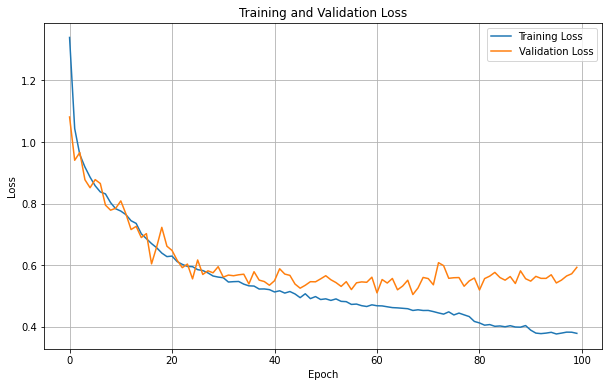

Test Accuracy: 79.40%


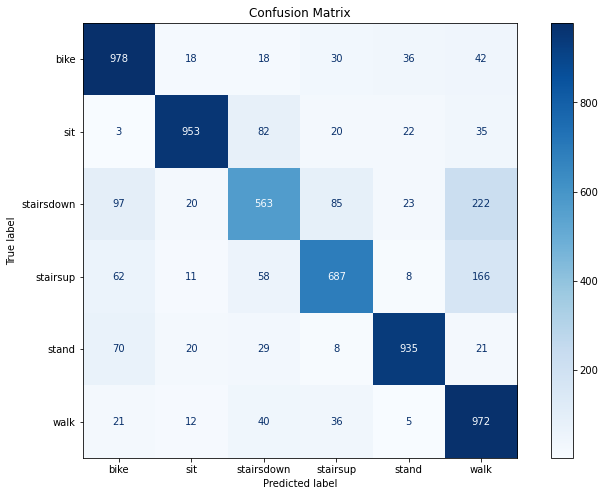

In [8]:
pickle_file_path = './dataset/phone_data.pkl'
df, label_encoder = load_data(pickle_file_path)

print(f"Dataset Shape: {df.shape}")

# Create datasets and dataloaders
dataset = SensorDataset(df)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=4)

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model, loss, and optimizer
model = DeepSenseModel(input_dims=INPUT_DIMENSION, num_axis=NUM_AXIS, num_classes=len(df['label'].unique()))
model.to(device)  # Move model to GPU if available

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=10, verbose=True
)

# Train the model
train_losses, val_losses = train_model(
    model, train_loader, test_loader, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, device=device
)

# Plot the training and validation loss
plot_loss(train_losses, val_losses)

# Test the model and visualize confusion matrix
test_model(model, test_loader, device=device, label_encoder=label_encoder)